In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import mstats
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from scipy.stats import randint

In [6]:
df = pd.read_excel("df_pretraiter2.xlsx", engine="openpyxl")

## Entrainement de modéle

In [7]:
pd.set_option('display.max_columns', None)
df.head()

,price,seller_type,mileage,brand,model,doors,origin,fiscal_power,condition,year,gearbox,fuel_type_encoded,region_encoded
0,365000,1,144999.5,Volkswagen,Touareg,5,NaN,12,4,2021,1,0,1
1,198000,1,2499.5,Opel,Corsa,5,WW au Maroc,6,5,2024,0,0,1
2,79000,1,174999.5,Renault,Megane,3,WW au Maroc,7,3,2009,0,0,1
3,93000,1,77499.5,Fiat,500,5,WW au Maroc,6,4,2017,0,0,1
4,340000,1,104999.5,Mercedes-Benz,Classe GLC,5,NaN,9,4,2018,1,0,1


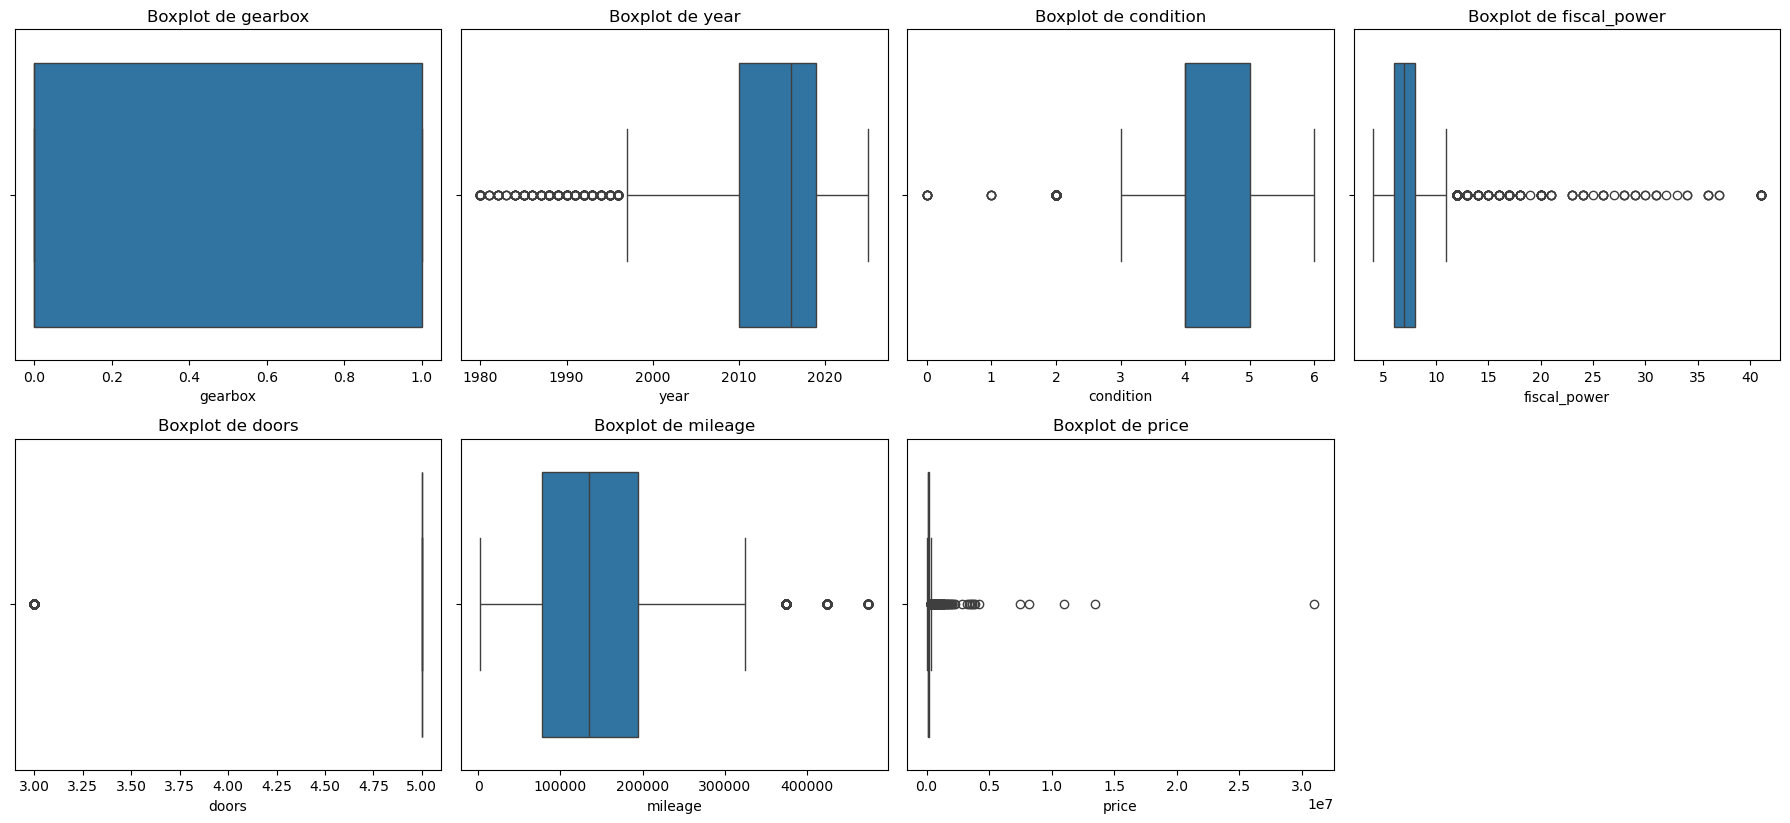

In [8]:
#head_element()
# Colonnes à analyser
cols = ['gearbox', 'year', 'condition', 'fiscal_power', 'doors', 'mileage', 'price']

# Création d'une figure avec plusieurs sous-graphes
plt.figure(figsize=(18, 12))

for i, col in enumerate(cols, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
    plt.tight_layout()

plt.show()

In [9]:
df['year'] = df['year'].astype(float)
def replace_outliers_with_mean(df, col):
    # Calcul des quartiles et IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Calcul de la moyenne sans les outliers
    mean_val = df.loc[(df[col] >= lower_bound) & (df[col] <= upper_bound), col].mean()
    
    # Remplacement des outliers par la moyenne
    df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = mean_val
    
    return df

# Colonnes numériques à traiter
numeric_cols = ['gearbox', 'year', 'condition', 'fiscal_power', 'doors', 'mileage', 'price']

for col in numeric_cols:
    df = replace_outliers_with_mean(df, col)

# Vérification
print(df[numeric_cols].describe())

            gearbox          year     condition  fiscal_power    doors  \
count  12348.000000  12348.000000  12348.000000  12348.000000  12348.0   
mean       0.376255   2014.698466      4.396461      7.083248      5.0   
std        0.484465      5.824988      0.715964      1.316493      0.0   
min        0.000000   1997.000000      3.000000      4.000000      5.0   
25%        0.000000   2011.000000      4.000000      6.000000      5.0   
50%        0.000000   2016.000000      4.000000      7.000000      5.0   
75%        1.000000   2019.000000      5.000000      8.000000      5.0   
max        1.000000   2025.000000      6.000000     11.000000      5.0   

             mileage          price  
count   12348.000000   12348.000000  
mean   137228.971410  137860.365617  
std     78339.494312   74399.224210  
min      2499.500000    6900.000000  
25%     77499.500000   81000.000000  
50%    134999.500000  130000.000000  
75%    184999.500000  175000.000000  
max    324999.500000  365000.

C:\Users\Client\AppData\Local\Temp\ipykernel_14576\3370661857.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3762552640103661' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = mean_val
C:\Users\Client\AppData\Local\Temp\ipykernel_14576\3370661857.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.39646133682831' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = mean_val
C:\Users\Client\AppData\Local\Temp\ipykernel_14576\3370661857.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.083247511156883' has dtype incompatible 

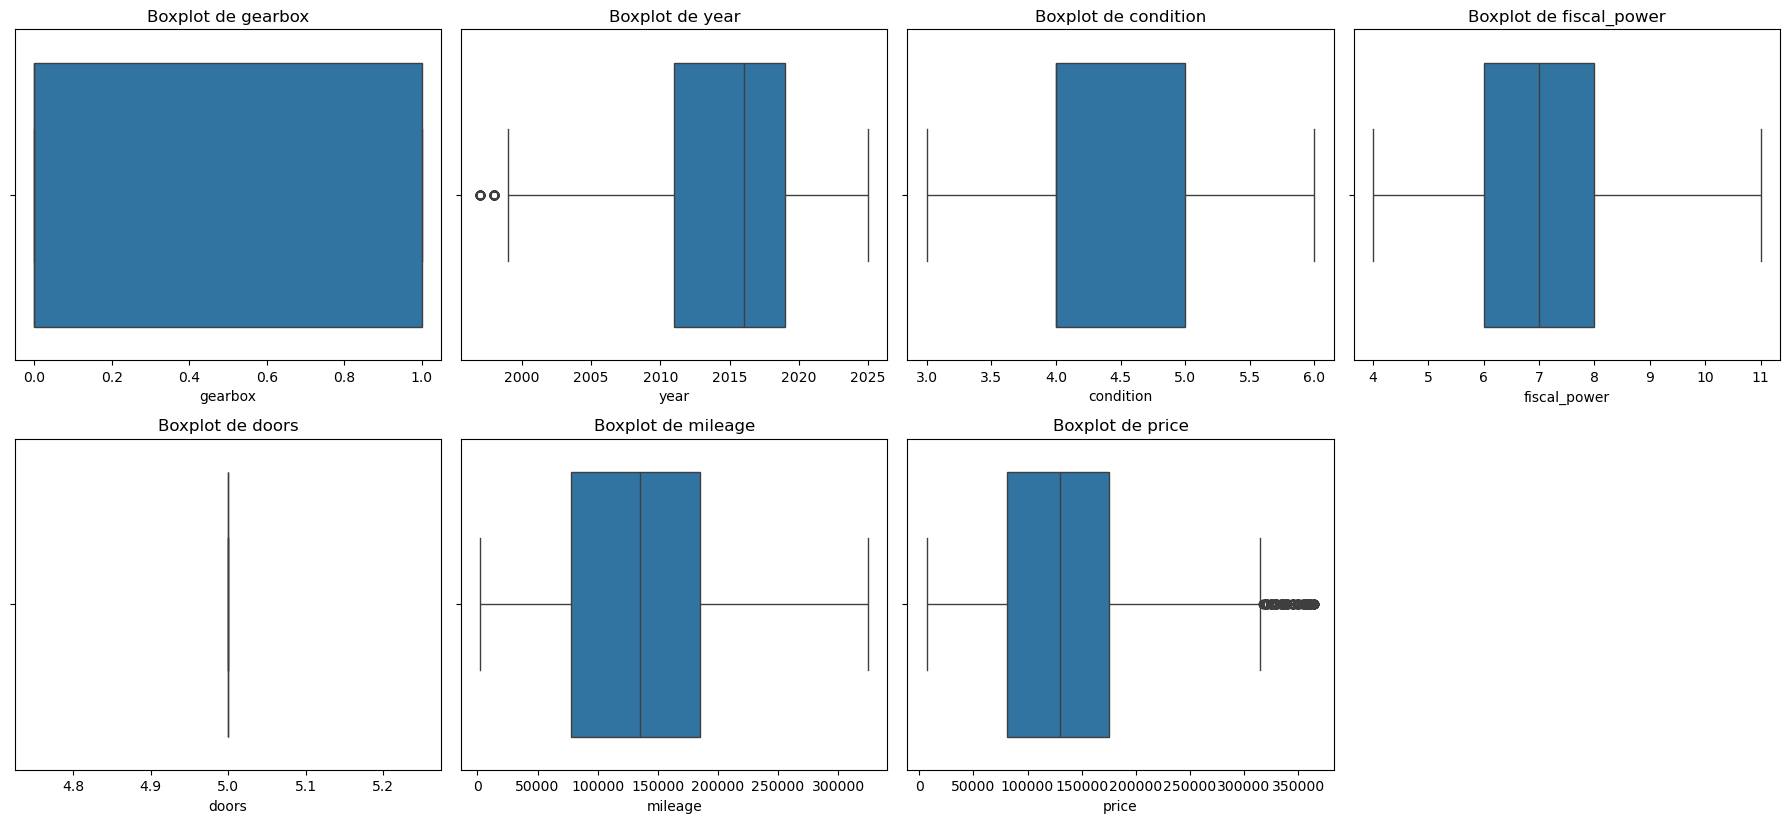

In [10]:
#head_element()
# Colonnes à analyser
cols = ['gearbox', 'year', 'condition', 'fiscal_power', 'doors', 'mileage', 'price']

# Création d'une figure avec plusieurs sous-graphes
plt.figure(figsize=(18, 12))

for i, col in enumerate(cols, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
    plt.tight_layout()

plt.show()

Nombre de valeurs > 300000 : 459
count     12348.000000
mean     137860.365617
std       74399.224210
min        6900.000000
25%       81000.000000
50%      130000.000000
75%      175000.000000
max      365000.000000
Name: price, dtype: float64


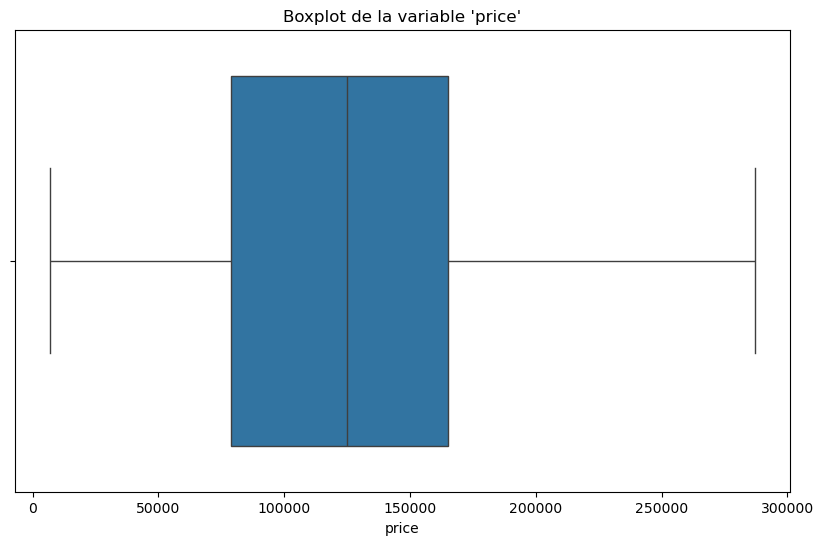

In [11]:
outliers_count = (df['price'] > 300000).sum()
print("Nombre de valeurs > 300000 :" ,outliers_count)
print(df['price'].describe())

Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.2 * IQR
df= df[df['price'] <= upper_limit]
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'])
plt.title("Boxplot de la variable 'price'")
plt.show()

In [182]:
# --- 1. Séparation features / target ---
X = df.drop('price', axis=1)
y = df['price']

# --- 2. Transformation logarithmique de la cible ---
# y = np.log1p(y)  # log(1 + y) pour gérer les zéros
# --- 3. Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


In [183]:
# --- 4. Calcul des modes nécessaires pour l’imputation ---
mode_origin_per_model = X_train.groupby('model')['origin'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
)
mode_origin_per_brand = X_train.groupby('brand')['origin'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
)
global_mode_origin = X_train['origin'].mode().iloc[0]

# --- 5. Imputation vectorisée pour 'origin' ---
def impute_origin(df):
    df = df.copy()
    df['origin'] = df['origin'].fillna(df['model'].map(mode_origin_per_model))
    df['origin'] = df['origin'].fillna(df['brand'].map(mode_origin_per_brand))
    df['origin'] = df['origin'].fillna(global_mode_origin)
    return df

X_train = impute_origin(X_train)
X_test = impute_origin(X_test)

# --- 6. Calcul des modes pour 'brand' et 'model' par 'origin' ---
mode_brand_per_origin = X_train.groupby('origin')['brand'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
)
mode_model_per_origin = X_train.groupby('origin')['model'].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan
)
global_mode_brand = X_train['brand'].mode().iloc[0]
global_mode_model = X_train['model'].mode().iloc[0]

# --- 7. Imputation vectorisée pour 'brand' et 'model' ---
def impute_brand(df):
    df = df.copy()
    df['brand'] = df['brand'].fillna(df['origin'].map(mode_brand_per_origin))
    df['brand'] = df['brand'].fillna(global_mode_brand)
    return df

def impute_model(df):
    df = df.copy()
    df['model'] = df['model'].fillna(df['origin'].map(mode_model_per_origin))
    df['model'] = df['model'].fillna(global_mode_model)
    return df

X_train = impute_brand(X_train)
X_train = impute_model(X_train)
X_test = impute_brand(X_test)
X_test = impute_model(X_test)

In [184]:
print(X_train)

       seller_type       mileage          brand      model  doors  \
935              1   22499.50000           Audi         Q3      5   
5526             0  137228.97141        Hyundai        i30      5   
10416            0   82499.50000          Volvo        V40      5   
5776             0  224999.50000     Volkswagen  Passat CC      5   
9576             0   87499.50000         Toyota      Yaris      5   
...            ...           ...            ...        ...    ...   
11908            0  174999.50000           Ford     Fiesta      5   
5561             0   57499.50000  Mercedes-Benz   Classe C      5   
5766             0  154999.50000     Volkswagen      Jetta      5   
958              0  274999.50000  Mercedes-Benz   Classe C      5   
7730             0  144999.50000        Renault     Kangoo      5   

                     origin  fiscal_power  condition    year  gearbox  \
935          Importée neuve     11.000000        6.0  2022.0      1.0   
5526            WW au Mar

In [185]:
# Pour X_train
print("Valeurs nulles dans X_train :")
print(X_train.isnull().sum())

# Pour X_test
print("\nValeurs nulles dans X_test :")
print(X_test.isnull().sum())
print(y_test)

Valeurs nulles dans X_train :
seller_type          0
mileage              0
brand                0
model                0
doors                0
origin               0
fiscal_power         0
condition            0
year                 0
gearbox              0
fuel_type_encoded    0
region_encoded       0
dtype: int64

Valeurs nulles dans X_test :
seller_type          0
mileage              0
brand                0
model                0
doors                0
origin               0
fiscal_power         0
condition            0
year                 0
gearbox              0
fuel_type_encoded    0
region_encoded       0
dtype: int64
10413     99000.000000
4207     195000.000000
6911      60000.000000
932      137860.365617
3570     135000.000000
             ...      
8605      85000.000000
956      137860.365617
5096      35000.000000
5198     195000.000000
6851     145000.000000
Name: price, Length: 3509, dtype: float64


In [186]:
# --- 8. Target encoding avec lissage ---
def target_encode_smooth(train_df, test_df, target_col, cat_col, m=10):
    global_mean = train_df[target_col].mean()
    agg = train_df.groupby(cat_col)[target_col].agg(['mean', 'count'])
    smooth = (agg['count'] * agg['mean'] + m * global_mean) / (agg['count'] + m)
    train_encoded = train_df[cat_col].map(smooth)
    test_encoded = test_df[cat_col].map(smooth).fillna(global_mean)
    return train_encoded, test_encoded

train_with_target = pd.concat([X_train, y_train], axis=1)

for col in ['brand', 'model', 'origin']:
    X_train[col + '_enc'], X_test[col + '_enc'] = target_encode_smooth(
        train_with_target, X_test, target_col='price', cat_col=col, m=10
    )

X_train = X_train.drop(['brand', 'model', 'origin'], axis=1)
X_test = X_test.drop(['brand', 'model', 'origin'], axis=1)


In [162]:
# X_train['car_age'] = 2024 - X_train['year']
# X_test['car_age'] = 2024 - X_test['year']
# X_train = X_train.drop(columns=['year'])
# X_test = X_test.drop(columns=['year'])
print(X_train)

       seller_type       mileage  doors  fiscal_power  condition    year  \
935              1   22499.50000      5     11.000000        6.0  2022.0   
5526             0  137228.97141      5      6.000000        3.0  2014.0   
10416            0   82499.50000      5      8.000000        5.0  2019.0   
5776             0  224999.50000      5      8.000000        4.0  2011.0   
9576             0   87499.50000      5      5.000000        4.0  2016.0   
...            ...           ...    ...           ...        ...     ...   
11908            0  174999.50000      5      6.000000        4.0  2008.0   
5561             0   57499.50000      5      7.083248        5.0  2022.0   
5766             0  154999.50000      5      8.000000        5.0  2017.0   
958              0  274999.50000      5      7.083248        4.0  2007.0   
7730             0  144999.50000      5      6.000000        5.0  2018.0   

       gearbox  fuel_type_encoded  region_encoded      brand_enc  \
935        1.0     

In [187]:
# --- 9. Standardisation ---
#pour toute les données
num_cols = ['mileage', 'fuel_type_encoded','fiscal_power','condition','year','doors', 'brand_enc','model_enc','origin_enc','region_encoded']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


In [188]:
print(X_train)
print(X_test)
# print(y_train)
# print(y_train)

       seller_type   mileage  doors  fiscal_power  condition      year  \
935              1 -1.479997    0.0      2.993593   2.258501  1.297938   
5526             0 -0.030678    0.0     -0.789340  -1.928830 -0.060433   
10416            0 -0.722048    0.0      0.723833   0.862724  0.788549   
5776             0  1.078082    0.0      0.723833  -0.533053 -0.569822   
9576             0 -0.658885    0.0     -1.545927  -0.533053  0.279160   
...            ...       ...    ...           ...        ...       ...   
11908            0  0.446458    0.0     -0.789340  -0.533053 -1.079211   
5561             0 -1.037860    0.0      0.030231   0.862724  1.297938   
5766             0  0.193808    0.0      0.723833   0.862724  0.448956   
958              0  1.709706    0.0      0.030231  -0.533053 -1.249007   
7730             0  0.067483    0.0     -0.789340   0.862724  0.618752   

       gearbox  fuel_type_encoded  region_encoded  brand_enc  model_enc  \
935        1.0           1.995543   

In [189]:
# --- 10. Recherche aléatoire d’hyperparamètres ---
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 30),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

print("Meilleurs paramètres :", random_search.best_params_)
print("Meilleur score (MSE négatif) :", random_search.best_score_)

best_rf = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Meilleurs paramètres : {'bootstrap': True, 'max_depth': 18, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 104}
Meilleur score (MSE négatif) : -607668460.906361


In [190]:
# --- 11. Validation croisée sur le meilleur modèle ---
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    best_rf,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

mse_scores = -cv_scores
rmse_scores = np.sqrt(mse_scores)
print(f"Validation croisée 5-fold RMSE du meilleur modèle : {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}")

Validation croisée 5-fold RMSE du meilleur modèle : 24647.3833 ± 418.2804


In [191]:
# --- 12. Prédictions ---
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# --- 13. Évaluation ---
def print_metrics(y_true, y_pred, dataset_name="Dataset"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"Performance sur {dataset_name} :")
    print(f"  MSE = {mse:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  MAE = {mae:.4f}")
    print(f"  R2 = {r2:.4f}\n")

print_metrics(y_train, y_train_pred, "Train")
print_metrics(y_test, y_test_pred, "Test")

Performance sur Train :
  MSE = 99092175.4762
  RMSE = 9954.5053
  MAE = 6395.3906
  R2 = 0.9739

Performance sur Test :
  MSE = 729335038.5905
  RMSE = 27006.2037
  MAE = 16721.8938
  R2 = 0.8078



In [ ]:
import shap

# --- SHAP Global Feature Importance ---
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# Visualisation globale
shap.summary_plot(shap_values, X_test, feature_names=X_train.columns, plot_type="bar")

# Visualisation détaillée (beeswarm plot)
shap.summary_plot(shap_values, X_test, feature_names=X_train.columns)

# --- Explication locale pour une prédiction spécifique ---
idx = 0  # Index de l'observation à expliquer
shap.force_plot(
    explainer.expected_value, 
    shap_values[idx], 
    X_test.iloc[idx], 
    feature_names=X_train.columns,
    matplotlib=True
)


In [ ]:
# colonnes_importantes = [
#     'model_enc',
#     'gearbox',
#     'fuel_type_encoded',
#     'brand_enc',
#     'mileage',
#     'fiscal_power',
#     'origin_enc',
#     'condition',
#     'region_encoded',
# ]

# X_train = X_train[colonnes_importantes]
# X_test = X_test[colonnes_importantes]

In [22]:
# from lime.lime_tabular import LimeTabularExplainer

# # Création de l'explainer LIME
# explainer_lime = LimeTabularExplainer(
#     training_data=X_train.values,
#     feature_names=X_train.columns.tolist(),
#     class_names=['price'],
#     mode='regression',
#     discretize_continuous=False,
#     verbose=True
# )

# # Explication pour une observation spécifique
# idx = 0  # Même index que pour SHAP
# exp = explainer_lime.explain_instance(
#     X_test.iloc[idx].values, 
#     best_rf.predict, 
#     num_features=5
# )

# # Affichage des résultats
# exp.show_in_notebook(show_table=True)

# # Export vers un fichier HTML
# exp.save_to_file('lime_explanation.html')


In [181]:
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Supposons que X_train, X_test, y_train, y_test sont déjà préparés comme dans votre pipeline
# print(X_train)
def print_metrics(y_true, y_pred, model_name="Model"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"Performance de {model_name} :")
    print(f"  MSE = {mse:.4f}")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  MAE = {mae:.4f}")
    print(f"  R2 = {r2:.4f}\n")

# 1. HistGradientBoostingRegressor (sklearn)
hgb = HistGradientBoostingRegressor(max_iter=200, max_depth=25, random_state=42)
hgb.fit(X_train, y_train)
y_train_pred = hgb.predict(X_train)
y_test_pred = hgb.predict(X_test)
print_metrics(y_train, y_train_pred, "HistGradientBoostingRegressor (sklearn)")
print_metrics(y_test, y_test_pred, "HistGradientBoostingRegressor (sklearn)")


Performance de HistGradientBoostingRegressor (sklearn) :
  MSE = 657538722.3668
  RMSE = 25642.5179
  MAE = 18594.0401
  R2 = 0.8270

Performance de HistGradientBoostingRegressor (sklearn) :
  MSE = 1167889175.5862
  RMSE = 34174.3936
  MAE = 24237.2238
  R2 = 0.6923



In [152]:
from sklearn.ensemble import HistGradientBoostingRegressor

models = {
    "HistGBR": HistGradientBoostingRegressor(max_iter=400, max_depth=45, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=150, max_depth=25, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=200, max_depth=25, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=200, depth=10, verbose=0, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print_metrics(y_train, model.predict(X_train), f"{name} - Train")
    print_metrics(y_test, model.predict(X_test), f"{name} - Test")

Performance de HistGBR - Train :
  MSE = 21493996.9686
  RMSE = 4636.1619
  MAE = 2653.5457
  R2 = 0.9943

Performance de HistGBR - Test :
  MSE = 3524395317.8461
  RMSE = 59366.6179
  MAE = 47164.5612
  R2 = 0.0714



XGBoostError: bad allocation

In [105]:
# 2. XGBoost
xgb = XGBRegressor(
    n_estimators=200,
    max_depth=25,
    learning_rate=0.1,
    random_state=42,
    verbosity=0,
    tree_method='hist'  # accélère l'entraînement
)
xgb.fit(X_train, y_train)
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)
print_metrics(y_train, y_train_pred, "XGBoost")
print_metrics(y_test, y_test_pred, "XGBoost")

Performance de XGBoost :
  MSE = 3169916.6187
  RMSE = 1780.4260
  MAE = 172.3912
  R2 = 0.9992

Performance de XGBoost :
  MSE = 836433065.7651
  RMSE = 28921.1526
  MAE = 17732.5053
  R2 = 0.7796



In [106]:
# 3. LightGBM
lgbm = LGBMRegressor(
    n_estimators=200,
    max_depth=25,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
lgbm.fit(X_train, y_train)
y_train_pred = lgbm.predict(X_train)
y_test_pred = lgbm.predict(X_test)
print_metrics(y_train, y_train_pred, "LightGBM")
print_metrics(y_test, y_test_pred, "LightGBM")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 404
[LightGBM] [Info] Number of data points in the train set: 8186, number of used features: 11
[LightGBM] [Info] Start training from score 127266.125149
Performance de LightGBM :
  MSE = 313325687.2750
  RMSE = 17701.0081
  MAE = 12061.7554
  R2 = 0.9176

Performance de LightGBM :
  MSE = 677299014.1555
  RMSE = 26024.9691
  MAE = 16661.4874
  R2 = 0.8215



In [107]:
# 4. CatBoost
cat = CatBoostRegressor(
    iterations=200,
    depth=8,  # CatBoost recommande souvent des profondeurs plus faibles
    learning_rate=0.1,
    random_seed=42,
    verbose=False
)
cat.fit(X_train, y_train)
y_train_pred = cat.predict(X_train)
y_test_pred = cat.predict(X_test)
print_metrics(y_train, y_train_pred, "CatBoost")
print_metrics(y_test, y_test_pred, "CatBoost")

Performance de CatBoost :
  MSE = 381453194.1541
  RMSE = 19530.8268
  MAE = 13489.3737
  R2 = 0.8996

Performance de CatBoost :
  MSE = 717395430.2057
  RMSE = 26784.2385
  MAE = 17300.5707
  R2 = 0.8110



In [56]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [10, 20, 30],
    'max_iter': [200, 300, 400],
    'min_samples_leaf': [10, 20, 30],
    'l2_regularization': [0.0, 1.0, 10.0],
}

model = HistGradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print_metrics(y_test, y_pred, "HistGBR Optimisé")


Fitting 3 folds for each of 243 candidates, totalling 729 fits


KeyboardInterrupt: 

In [29]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 400],
    'max_depth': [10, 20, 30],
    'num_leaves': [31, 50, 100],
    'min_child_samples': [10, 20, 30],
    'reg_alpha': [0.0, 0.5, 1.0],
    'reg_lambda': [0.0, 0.5, 1.0],
}

lgb = LGBMRegressor(random_state=42)
grid_search_lgb = GridSearchCV(lgb, param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid_search_lgb.fit(X_train, y_train)

best_lgb = grid_search_lgb.best_estimator_
y_pred_lgb = best_lgb.predict(X_test)

print_metrics(y_test, y_pred_lgb, "LightGBM Optimisé")


Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 391
[LightGBM] [Info] Number of data points in the train set: 8186, number of used features: 10
[LightGBM] [Info] Start training from score 127266.125149
Performance de LightGBM Optimisé :
  MSE = 669389620.7342
  RMSE = 25872.5650
  MAE = 16324.1435
  R2 = 0.8236

